In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, shapiro, kruskal, chi2_contingency, levene
from statsmodels.graphics.gofplots import qqplot

In [2]:
yulu_data = pd.read_csv('https://raw.githubusercontent.com/AKinbusola/Statistical-Analysis-for-the-demand-for-shared-electric-cycles-in-the-Indian-market/main/yulu.csv')
yulu_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


## Exploratory Data Analysis

In [3]:
yulu_data.shape

(10886, 12)

there are 10886 rows and 12 columns

In [4]:
yulu_data.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

No null values found

In [5]:
print(yulu_data.dtypes)

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


In [6]:
## Converting 'datetime' column to type datetime
yulu_data['datetime']= pd.to_datetime(yulu_data['datetime'])

In [7]:
## Creating new column time and month from datetime
yulu_data['time']= yulu_data['datetime'].dt.hour.astype('str')
yulu_data['month']= yulu_data['datetime'].dt.month.astype('str')
yulu_data['year']= yulu_data['datetime'].dt.year.astype('str')

we can drop datetime column now, as we have slipt the datetime column to other columns

In [8]:
yulu_data=yulu_data.drop('datetime', axis=1)
yulu_data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,time,month,year
0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,1,2011
1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1,2011
2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,1,2011
3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,1,2011
4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19,12,2012
10882,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20,12,2012
10883,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21,12,2012
10884,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22,12,2012


In [10]:
## Converting seasons, holiday, workingday and weather to categorical columns
yulu_data[['season','holiday','workingday','weather']] = yulu_data[['season','holiday','workingday','weather']].astype('str')

yulu_data.dtypes

season         object
holiday        object
workingday     object
weather        object
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
time           object
month          object
year           object
dtype: object

From the data columns, let us consider 'count' as north star metric and the target column, as at the end of the day metric which is measured for yulu business is total no of bikes rented per day.

In [11]:
target = yulu_data['count']

cat_cols = list(yulu_data.columns[yulu_data.dtypes == 'object'])
cat_cols

['season', 'holiday', 'workingday', 'weather', 'time', 'month', 'year']

In [12]:
num_cols = list(yulu_data.columns[(yulu_data.dtypes!='object')& (yulu_data.columns!='count')])
num_cols

['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']

## Visual Analysis


##### Univariate Analysis

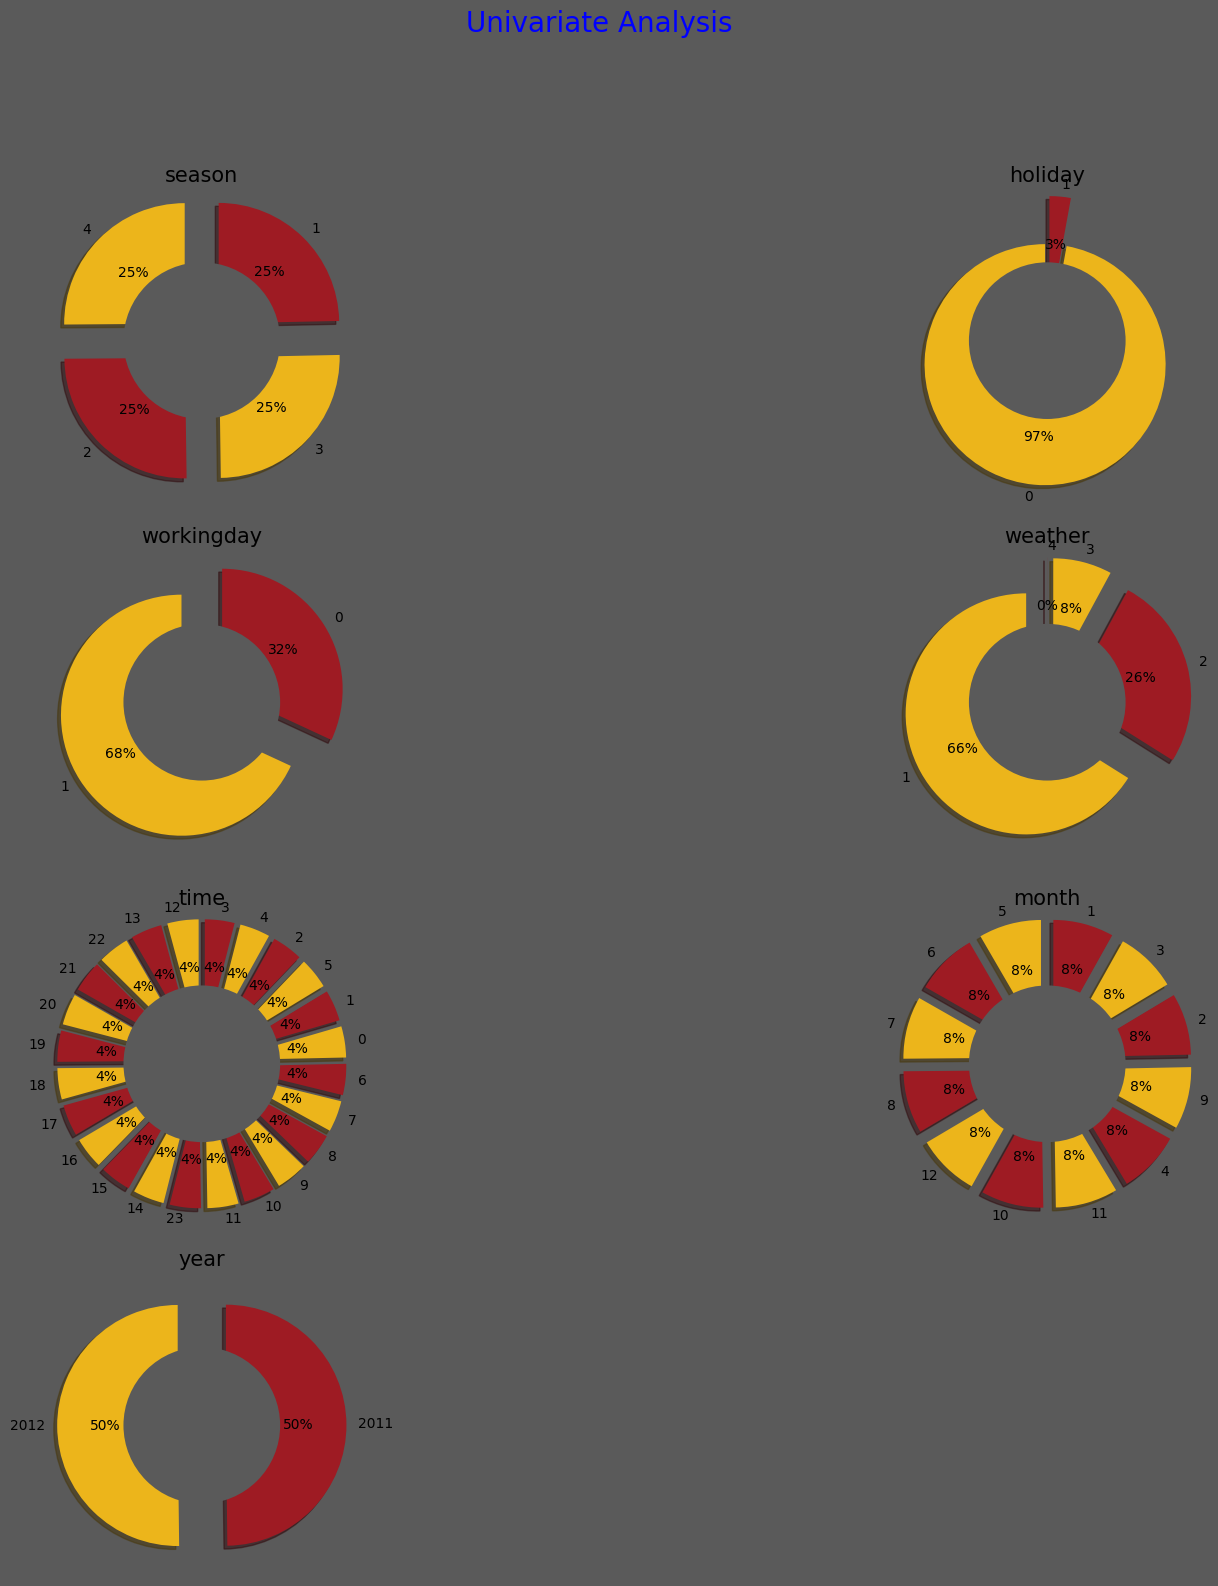

In [13]:
yulu_color_palette = sns.color_palette(['#ecb51b','#9e1b23'])
fig = plt.figure(figsize=(20,18))
fig.set_facecolor("#5a5a5a")
for n,col in enumerate(cat_cols):
    explode = yulu_data[col].nunique()*[0.2]
    plt.subplot(int(len(cat_cols)/2 +1), 2, n+1)
    plt.pie(list(yulu_data[col].value_counts().values),
            labels = list(yulu_data[col].value_counts().index), autopct='%.0f%%', shadow= True,
            startangle = 90, colors = yulu_color_palette, radius= 1, explode = explode )
    hole = plt.Circle((0, 0), 0.65, facecolor='#5a5a5a')
    plt.gcf().gca().add_artist(hole)
    plt.title(col, fontsize = 15)
    plt.xticks(rotation = 45)
fig.suptitle("Univariate Analysis", fontsize= 20, color = 'blue')
plt.show()

From the above plots we can observe that:

    * There are 4 categories in seasons which are equally distributed.
    * The holiday column has 2 categories which are 0 with 97% datapoints and 1 with 3% datapoints.
    * The workingday has 2 categories which are 0 with 32% datapoints and 1 with 68% datapoints.
    * The weather column has four categories, which are 1 with 65% datapoints, 2 with 26% datapoints, 3 with 8% and 4 with 0% datapoints.
    * The time and month and year columns has equal distributions.

#### Bivariate Analysis

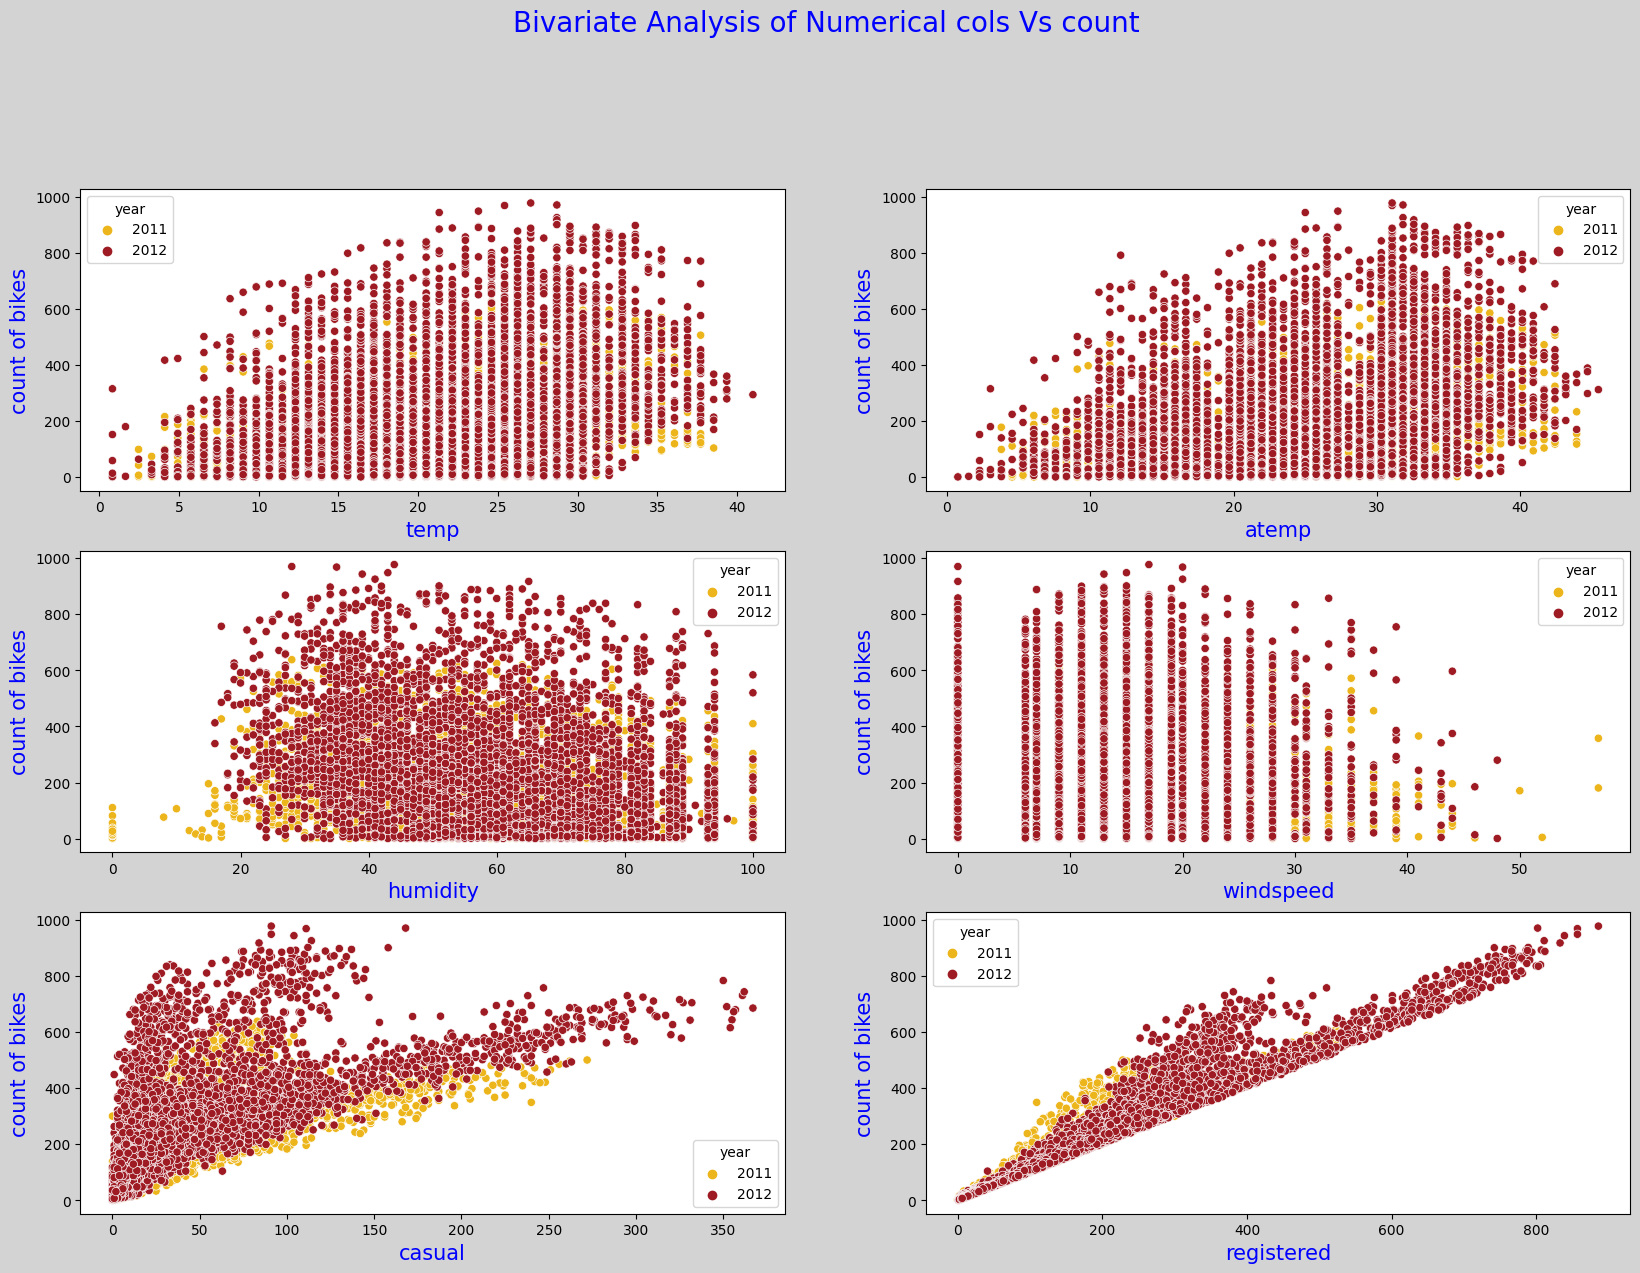

In [14]:
fig = plt.figure(figsize=(20,18))
fig.set_facecolor("lightgrey")
for i,col in enumerate(num_cols):
    plt.subplot(int(len(num_cols)/2 +1), 2, i+1)
    sns.scatterplot(x=yulu_data[col], y= target,hue = yulu_data['year'], palette = yulu_color_palette)
    plt.xlabel(col,fontsize =15, color = 'blue')
    plt.ylabel("count of bikes", fontsize = 15, color = 'blue')
fig.suptitle("Bivariate Analysis of Numerical cols Vs count ", fontsize= 20, color = 'blue')
plt.show()

From the above plot we can observe that :

        - Count of bikes is high when the temperature is between 20-30.
        - As count of casual and registered bikes increases total count increases.
        - Wind speed and humidity has not much effect of count of bikes.
        - Overall count of bikes rented in 2012 is greater than 2011.

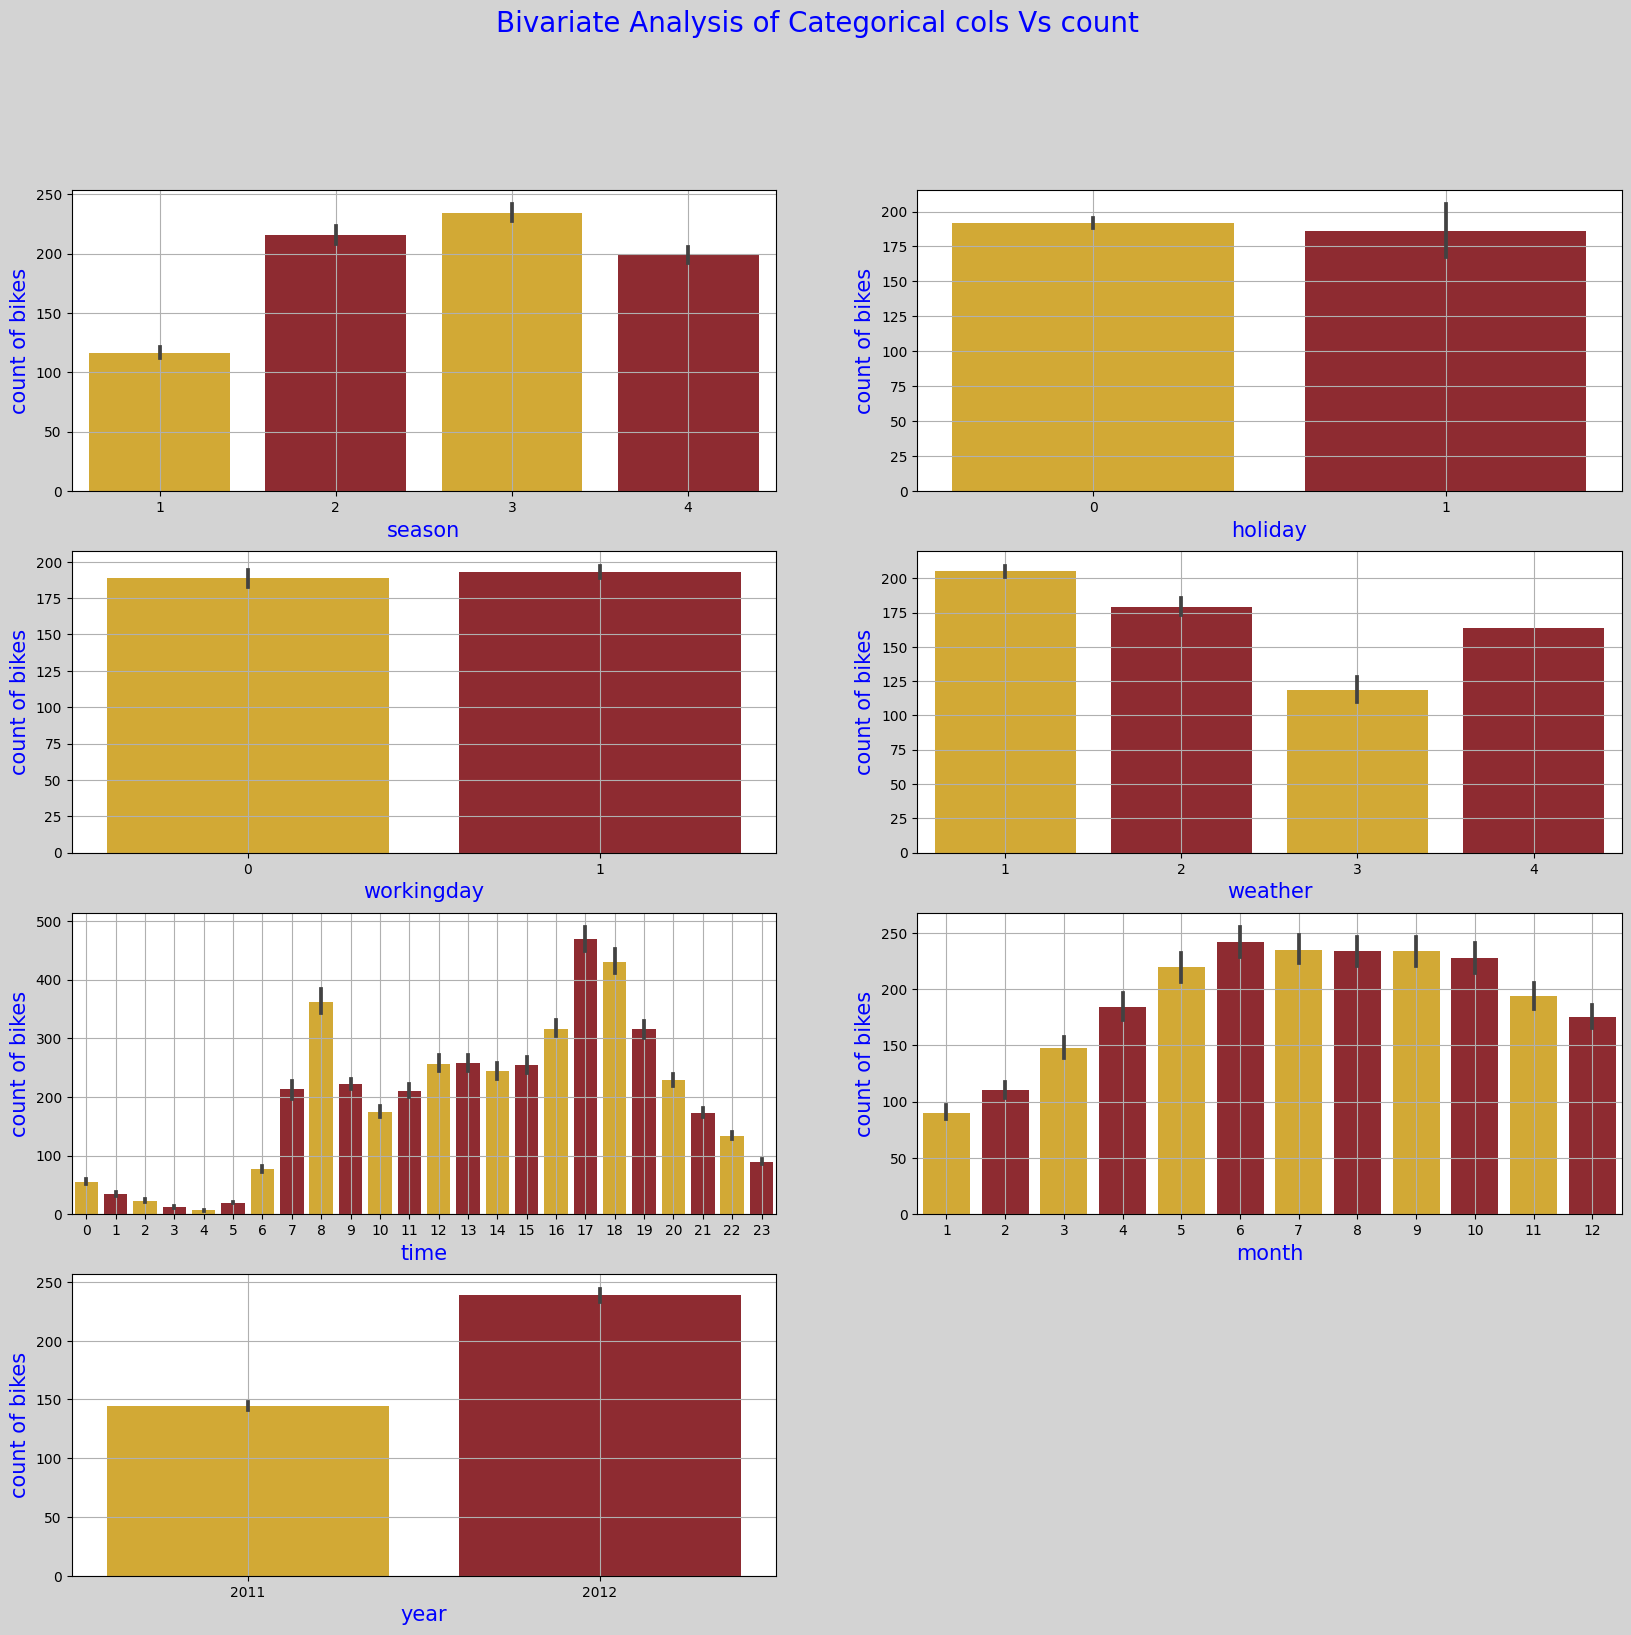

In [15]:
yulu_color_palette = sns.color_palette(['#ecb51b', '#9e1b23'])
fig = plt.figure(figsize=(20,18))
fig.set_facecolor("lightgrey")
for i,col in enumerate(cat_cols):
    plt.subplot(int(len(cat_cols)/2 +1), 2, i+1)
    sns.barplot(x=yulu_data[col], y= target, palette = yulu_color_palette)
    plt.grid(True)
    plt.xlabel(col,fontsize =15, color = 'blue')
    plt.ylabel("count of bikes", fontsize = 15, color = 'blue')
fig.suptitle("Bivariate Analysis of Categorical cols Vs count ", fontsize= 20, color = 'blue')
plt.show()

From the above plots we can observe that:

    - count of bikes are more in season 3 and less in season 1.
    - count of bikes is more on non- holiday than holiday.
    - count of bikes nearly equal on both working and non working days.
    - Number of bikes rented is high when weather is clear and low when there is little rains.
    - Number of bikes renteis high from the afternoon and gradually decreased to night and low after 12am to 5am.
    - Least number of bikes are rented in the month of January and maximum number in June.
    - Number of bikes rented in 2012 is more than 2011.

#### Multi-variate Analysis

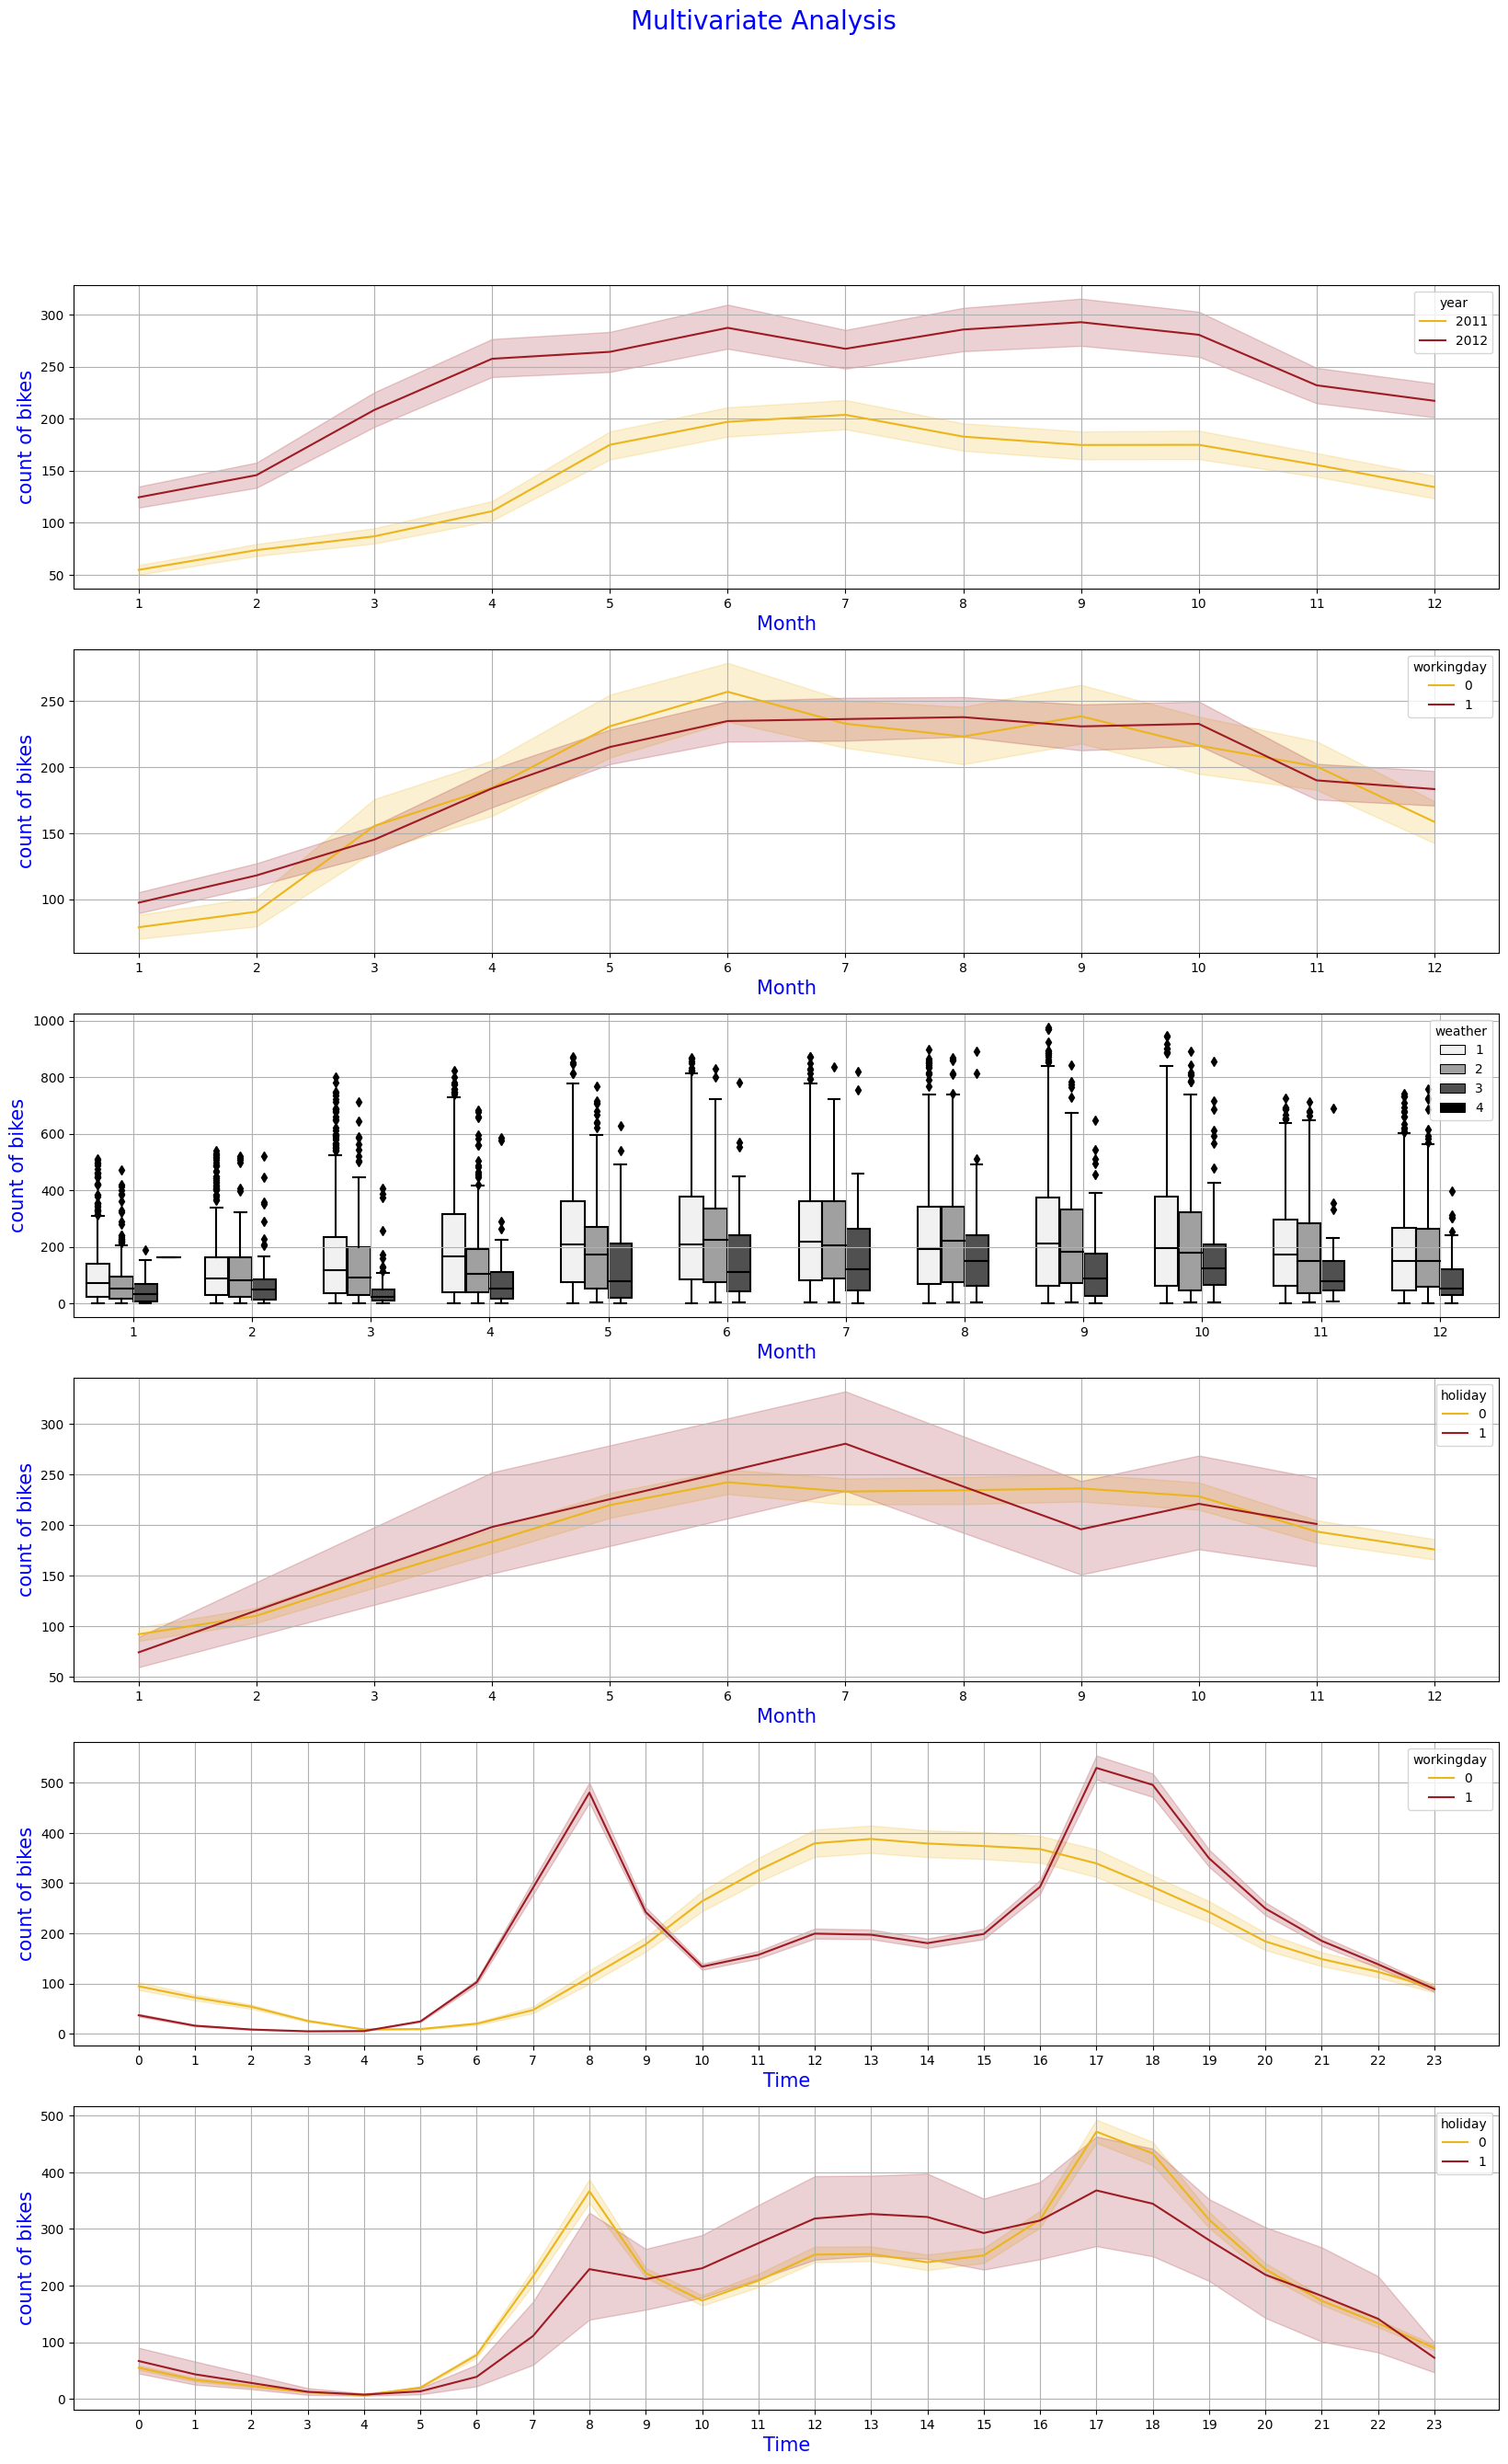

In [17]:
plt.figure(figsize=(20,30))

plt.subplot(611)
sns.lineplot(x=yulu_data['month'],y=target, hue = yulu_data['year'], palette = yulu_color_palette)
plt.xlabel('Month',fontsize =15, color = 'blue')
plt.ylabel("count of bikes", fontsize = 15, color = 'blue')
plt.grid(True)

plt.subplot(612)
sns.lineplot(x=yulu_data['month'],y=target, hue = yulu_data['workingday'], palette = yulu_color_palette)
plt.xlabel('Month',fontsize =15, color = 'blue')
plt.ylabel("count of bikes", fontsize = 15, color = 'blue')
plt.grid(True)

plt.subplot(613)
sns.boxplot(x=yulu_data['month'],y=target, hue = yulu_data['weather'], color='black')
plt.xlabel('Month',fontsize =15, color = 'blue')
plt.ylabel("count of bikes", fontsize = 15, color = 'blue')
plt.grid(True)

plt.subplot(614)
sns.lineplot(x=yulu_data['month'],y=target, hue = yulu_data['holiday'], palette = yulu_color_palette)
plt.xlabel('Month',fontsize =15, color = 'blue')
plt.ylabel("count of bikes", fontsize = 15, color = 'blue')
plt.grid(True)

plt.subplot(615)
sns.lineplot(x=yulu_data['time'],y=target, hue = yulu_data['workingday'], palette = yulu_color_palette)
plt.xlabel('Time',fontsize =15, color = 'blue')
plt.ylabel("count of bikes", fontsize = 15, color = 'blue')
plt.grid(True)

plt.subplot(616)
sns.lineplot(x=yulu_data['time'],y=target, hue = yulu_data['holiday'], palette = yulu_color_palette)
plt.xlabel('Time',fontsize =15, color = 'blue')
plt.ylabel("count of bikes", fontsize = 15, color = 'blue')
plt.grid(True)

plt.suptitle("Multivariate Analysis", fontsize= 20, color = 'blue')
plt.show()

From the above plots of multivariate analysis we observe that:

    - count of bikes rented in 2012 are higher than 2011 and overall consitency is mainted between months may to october.
    - In any month the count of bikes rented on either working day or non-working day are nearly equal.
    - Only three types of weathers are observed in all the months except in jan, all the four types of weather were observed. Weather is consistent from may to october.
    - Count of bikes on holidays are higher only in the month of july and lower in the month of september. In the other months the count of bikes is equal on holidys and non-holidays.
    - Count of bikes rented on working days raised from 5am to 8am and then again raised in the eveing 5pm.
    - count of bikes rented on holidays and non-holidays follow nearly same pattern.

# Outliers

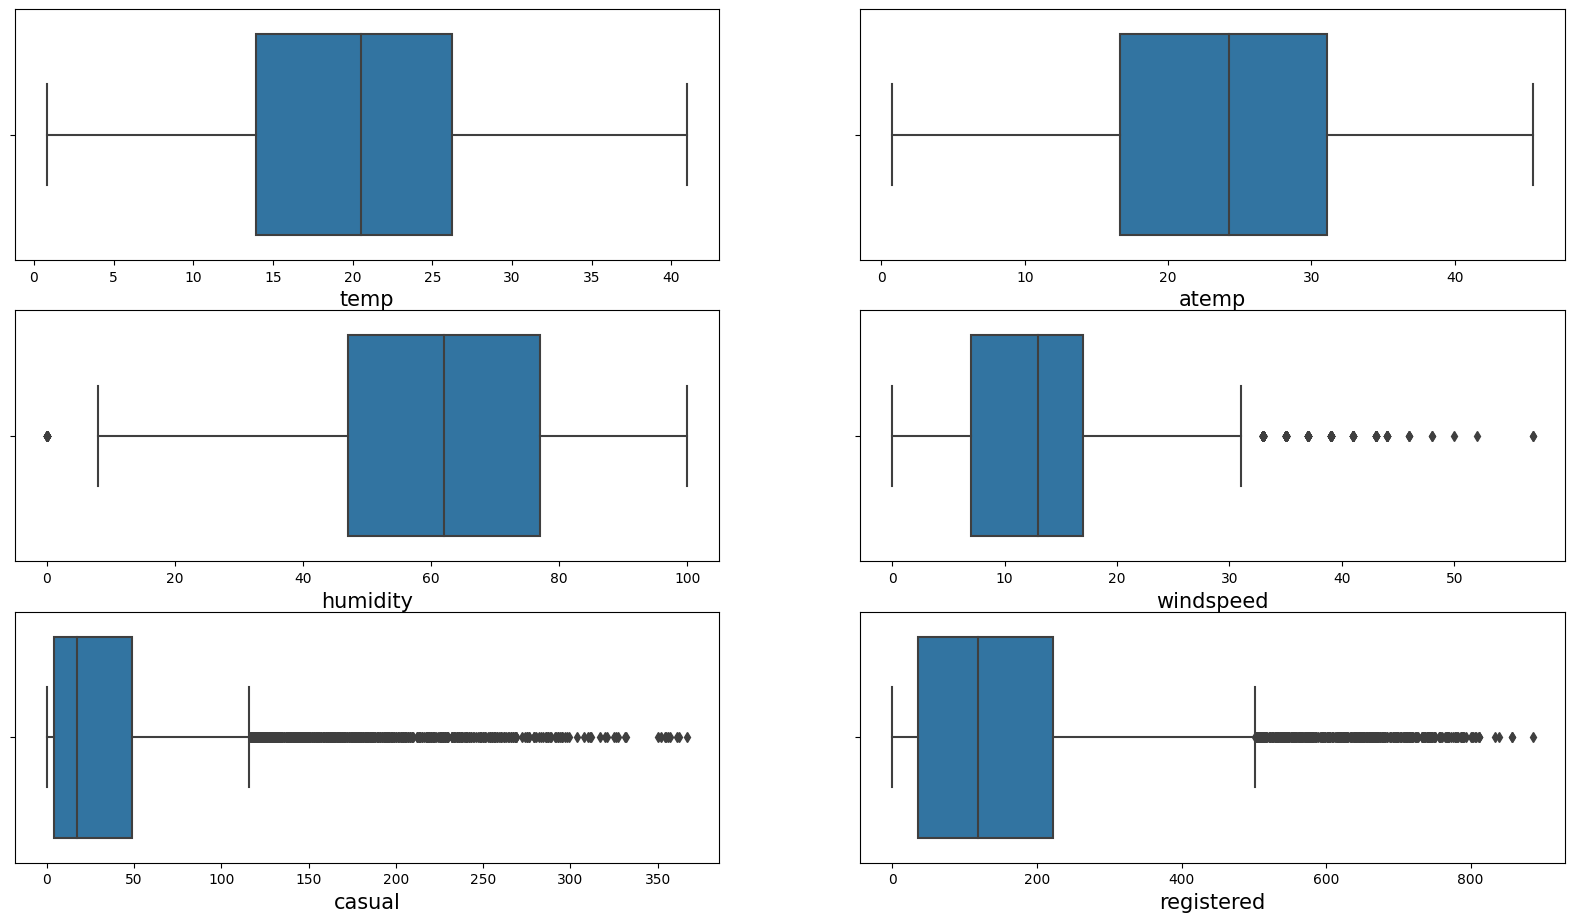

In [18]:
#outliers in all numerical columns
plt.figure(figsize=(20,15))
for i,col in enumerate(num_cols):
    plt.subplot(int(len(num_cols)/2)+1, 2, i+1)
    sns.boxplot(x= yulu_data[col])
    plt.xlabel(col, fontsize=15)
plt.show()

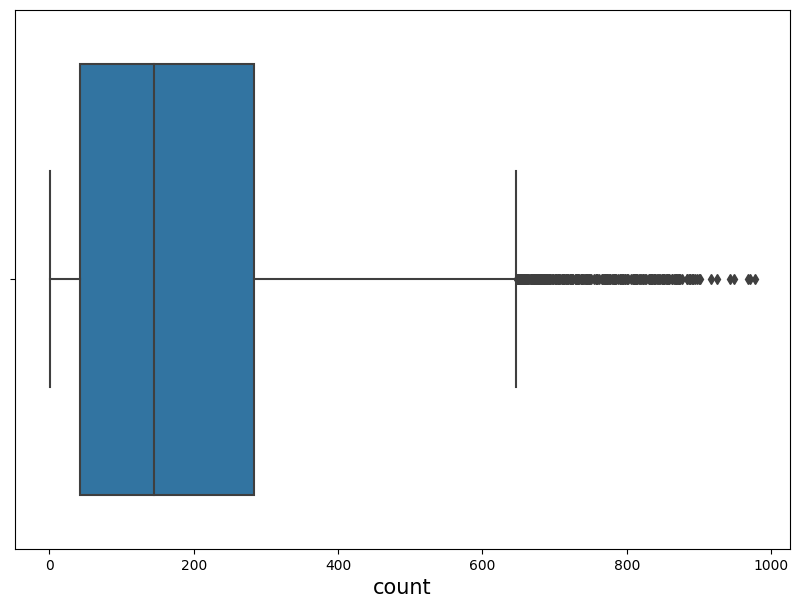

In [19]:
#checking for outliers in count column using box plot method
plt.figure(figsize=(10,7))
sns.boxplot(x= target)
plt.xlabel('count', fontsize=15)
plt.show()

- Outliers are observed in count, casual and registered coulumns.

In [20]:
#checking for outliers in count col using IQR method

Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)

IQR = Q3-Q1

lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR

yulu_data[(yulu_data['count']< lower_bound) | (yulu_data['count'] > upper_bound)]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,time,month,year
6611,1,0,1,2,24.60,31.060,43,12.9980,89,623,712,18,3,2012
6634,1,0,1,1,28.70,31.820,37,7.0015,62,614,676,17,3,2012
6635,1,0,1,1,28.70,31.820,34,19.9995,96,638,734,18,3,2012
6649,1,0,1,1,18.04,21.970,82,0.0000,34,628,662,8,3,2012
6658,1,0,1,1,28.70,31.820,28,6.0032,140,642,782,17,3,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,4,0,1,2,13.94,15.150,61,19.9995,16,708,724,8,12,2012
10702,4,0,1,2,10.66,12.880,65,11.0014,18,670,688,8,12,2012
10726,4,0,1,1,9.84,11.365,60,12.9980,24,655,679,8,12,2012
10846,4,0,1,1,15.58,19.695,94,0.0000,10,652,662,8,12,2012


- As count is the north star metric colum for analysis, we calculate outliers for count using IQR method and checked the outliers less than lowerbound and greater than upperbound and noticed that there are 300 ouliers.

#### Using Log trasformation for reducing the impact of outliers in count column

In [21]:
yulu_data['log_count']= [np.log(x) for x in yulu_data['count']]
yulu_data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,time,month,year,log_count
0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,1,2011,2.772589
1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1,2011,3.688879
2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,1,2011,3.465736
3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,1,2011,2.564949
4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,1,2011,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19,12,2012,5.817111
10882,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20,12,2012,5.484797
10883,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21,12,2012,5.123964
10884,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22,12,2012,4.859812


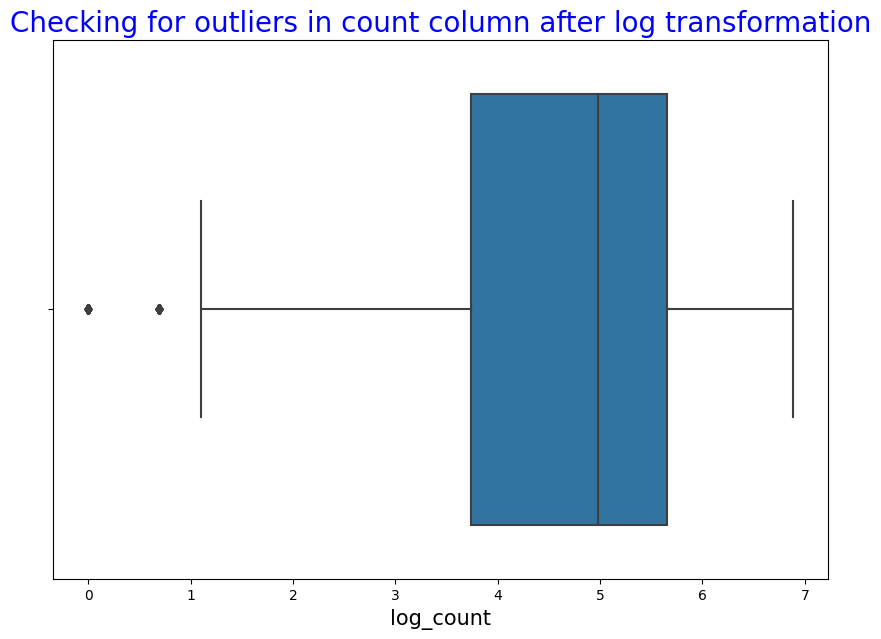

In [22]:
plt.figure(figsize=(10,7))
sns.boxplot(x= yulu_data['log_count'])
plt.xlabel("log_count", fontsize=15)
plt.title("Checking for outliers in count column after log transformation", fontsize=20, color='blue')
plt.show()

 - Outliers are low in log_count compared to count. So we proceed with analysis based on log_count.

In [23]:
#Analysis of numerical Variables
yulu_data[num_cols].describe()

,temp,atemp,humidity,windspeed,casual,registered
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000


In [24]:
#Analysis of categorical variable
yulu_data[cat_cols].describe(include='object')

,season,holiday,workingday,weather,time,month,year
count,10886,10886,10886,10886,10886,10886,10886
unique,4,2,2,4,24,12,2
top,4,0,1,1,12,5,2012
freq,2734,10575,7412,7192,456,912,5464


# Hypothesis Testing

# 1. Checking if numerical columns have correlation with count

In [25]:
for col in num_cols:
    val = np.corrcoef(yulu_data[col].rank(), yulu_data['log_count'].rank())[0,1]
    if val> 0 :
        print('There is +ve relation between count and', col,"- corrcoef: ",np.round(val,2))
    if val == 0:
        print('There is no relation between count and ', col,"- corrcoef: ",np.round(val,2))
    if val< 0:
        print('There is -ve relation between count and ', col,"- corrcoef: ",np.round(val,2))

There is +ve relation between count and temp - corrcoef:  0.41
There is +ve relation between count and atemp - corrcoef:  0.41
There is -ve relation between count and  humidity - corrcoef:  -0.35
There is +ve relation between count and windspeed - corrcoef:  0.14
There is +ve relation between count and casual - corrcoef:  0.85
There is +ve relation between count and registered - corrcoef:  0.99


From the above calculated data we can say that count of bikes rented depends on temp, windspeed and strongly dependent on casual and registered columns. count is negatively dependent on humidity. The less humid the weather is more the bikes are rented

# 2. Checking if Working Day has an effect on the number of electric cycles rented

In [26]:
workingday_0_count = yulu_data[yulu_data['workingday']=='0']['log_count']
workingday_1_count = yulu_data[yulu_data['workingday']=='1']['log_count']

H0 = 'count of bikes rented doesnot depend on workingday' #says the means are equal
Ha = 'count of bikes rented depend on workingday' # says means are not equal

alpha = 0.05

_, p_val = ttest_ind(workingday_0_count,workingday_1_count, alternative= 'less')

if p_val < alpha:
    print("p_value: ", np.round(p_val,2),'\n',"Reject H0: count of bikes rented on non-working day is less than working day")
else:
     print("p_value: ", np.round(p_val,2),'\n',"Unable to Reject H0:", H0)

p_value:  0.97 
 Unable to Reject H0: count of bikes rented doesnot depend on workingday


From the 2-sample ttest done the p-vaue is greater than alpha, so there are no enough evidences to reject null hypothesis, which concludes "The count of rented bikes doesnot depend on workingday."

#3. Checking if count of bikes depends on season

####a. CHECKING IF DATA IS NORMALLY DISTRIBUTED.

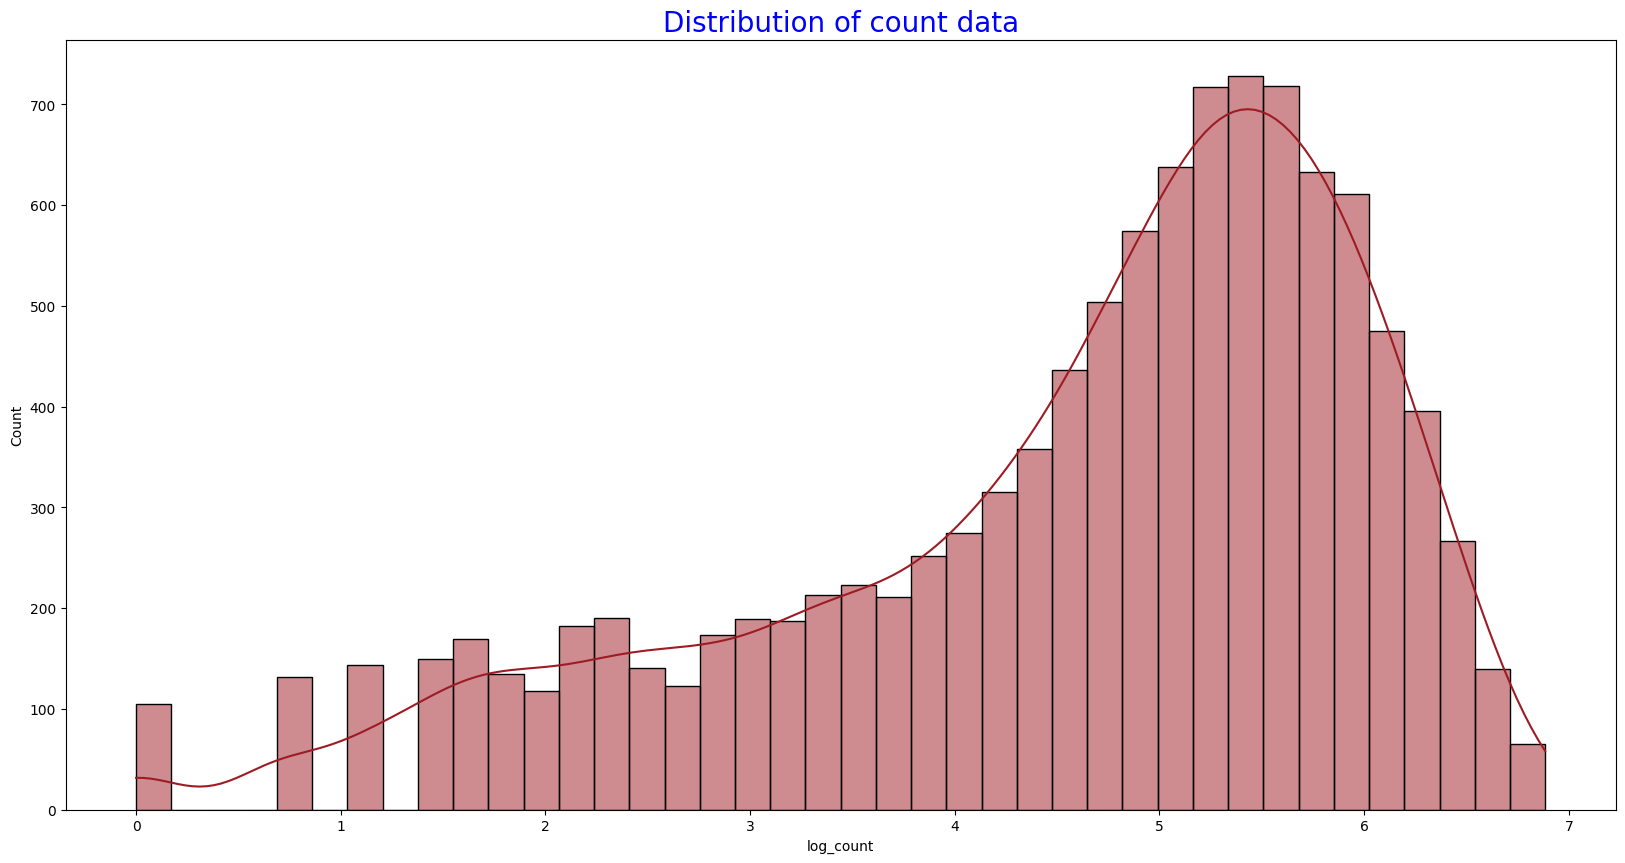

In [27]:
# checking if the count data is normal using histplot

plt.figure(figsize=(20,10))
sns.histplot(yulu_data['log_count'], kde= True, color = '#9e1b23')
plt.title("Distribution of count data", fontsize = 20, color = 'blue')
plt.show()

count data is not normal from the above histplot.

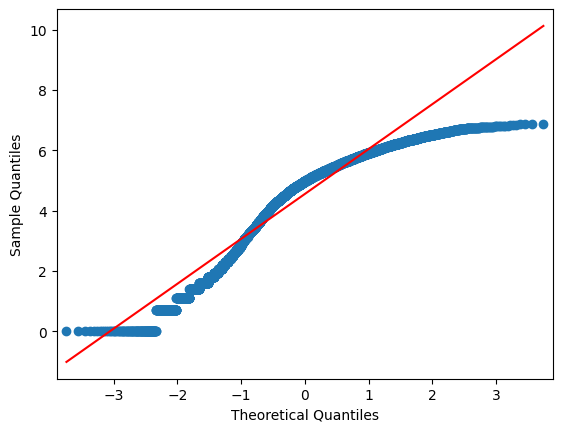

In [28]:
#checking if the count data is normal using qqplot
qqplot(yulu_data['log_count'], line='s')
plt.show()

Even with qqplot the count data is not normal.

In [29]:
#checking if the count data is normal using shapiro test

H0 = 'count data is normal' # says count is normally distributed
Ha = 'count data is not normal' #says count is not normally distributed

alpha = 0.05

_,p_val = shapiro(yulu_data['log_count'].sample(100))

if p_val < alpha:
    print("p_value: ", np.round(p_val,2),"Reject H0:", Ha)
else:
     print("p_value: ", np.round(p_val,2),"Unable to Reject H0:", H)

p_value:  0.0 Reject H0: count data is not normal


From the histplot, qqplot and shapiro test results we conclude that count is not normally distributed

#### 2. CHECKING FOR EQUAL VARIANCE FOR DIFFERENT CATEGORIES USING LEVENS TEST.

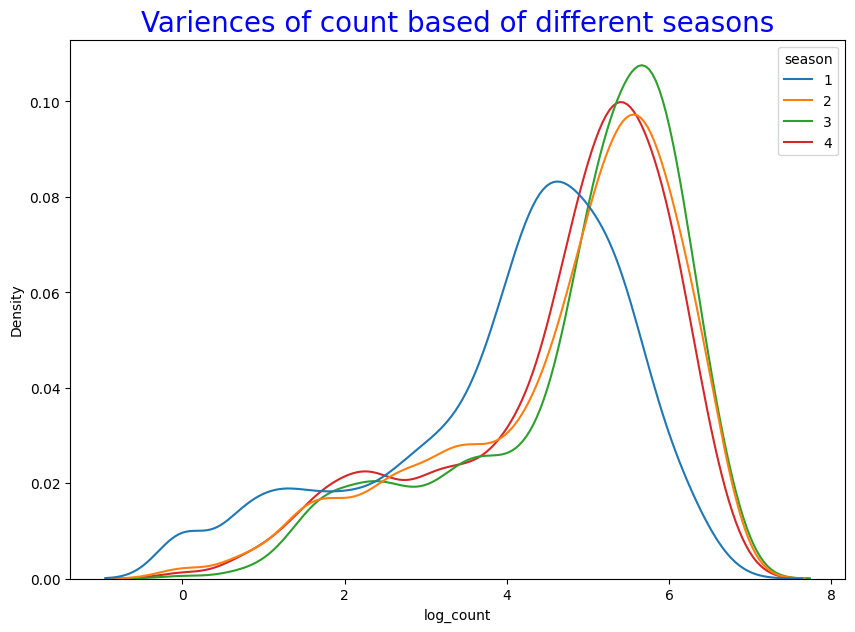

In [30]:
# dividing data based on seasons

season1 = yulu_data[yulu_data['season']== '1']['log_count']
season2 = yulu_data[yulu_data['season']== '2']['log_count']
season3 = yulu_data[yulu_data['season']== '3']['log_count']
season4 = yulu_data[yulu_data['season']== '4']['log_count']

plt.figure(figsize=(10,7))
sns.kdeplot(x= yulu_data['log_count'], hue = yulu_data['season'])
plt.title("Variences of count based of different seasons", fontsize=20, color= 'blue')
plt.show()

In [31]:
H0 = 'Distributions have equal varience'
Ha = 'Distributions donot have equal varience'

alpha = 0.05

_,p_val = levene(season1,season2,season3,season4)

if p_val < alpha:
    print("p_value: ", np.round(p_val,2),"Reject H0:", Ha)
else:
     print("p_value: ", np.round(p_val,2),"Unable to Reject H0:", H0)

p_value:  0.0 Reject H0: Distributions donot have equal varience


  From the above kdeplot and Leven's test results we an conclude that the groups are not equally distributed.

#### 3. CHECKING IF EACH CATEGORY DATA IS INDEPENDENT OF EACH OTHER.

As from the first and second assumptions failed,ie the data is not normally distributed and doenot have equal variences, going for kruskal's test.

In [32]:
#kruskal test for checking if count of bikes depend on season

H0 = 'count of bikes rented does not vary with season' # says all groups have same mean
Ha = 'count of bikes rented vary with season' # says all atleat one or more groups have different mean

alpha = 0.05

_, p_val = kruskal(season1,season2, season3, season4)
if p_val < alpha:
    print("p_value: ", np.round(p_val,2),"Reject H0:", Ha)
else:
     print("p_value: ", np.round(p_val,2),"Unable to Reject H0:", H)

p_value:  0.0 Reject H0: count of bikes rented vary with season


From the Kruskal's test result we conclude that the count of bikes rented vary with season.

# 4. Checking if count depends on weather

In [34]:
# grouping count based of weather categories

weather1 = yulu_data[yulu_data['weather']== '1']['log_count']
weather2 = yulu_data[yulu_data['weather']== '2']['log_count']
weather3 = yulu_data[yulu_data['weather']== '3']['log_count']
weather4 = yulu_data[yulu_data['weather']== '4']['log_count']

# As from the shapiro test we know that count is not normally distributed we go with kruskal's test
# kruskal test for checking if count of bikes depend on weather

H0 = 'count of bikes rented does not vary with weather' # says all groups have same mean
Ha = 'count of bikes rented vary with weather' # says one or more groups have different mean

_, p_val = kruskal(season1, season2, season3, season4)

if p_val < alpha:
    print("p_value: ", np.round(p_val,2),"Reject H0:", Ha)
else:
     print("p_value: ", np.round(p_val,2),"Unable to Reject H0:", H0)

p_value:  0.0 Reject H0: count of bikes rented vary with weather


 From the above kruskal's test on grouped count data based on season we say that count of bikes rented vary with weather.

# 5. Checking if weather is dependent on the season
As weather and season are both categorial columns we use Chisquare test.

In [35]:
# Creating crosstab for season and weather.
season_weather_cross_tab = pd.crosstab(yulu_data.season, yulu_data.weather)
season_weather_cross_tab

H0= 'weather and season are independent'
Ha= 'weather and season are dependent'

alpha = 0.05

_,p_val,_,_ = chi2_contingency(season_weather_cross_tab)

if p_val < alpha:
    print("p_value: ", np.round(p_val,2),"Reject H0:", Ha)
else:
     print("p_value: ", np.round(p_val,2),"Unable to Reject H0:", H0)

p_value:  0.0 Reject H0: weather and season are dependent


From the above chisquare contingency test result we conclude that "weather and season are dependent